import modules and get command-line parameters if running as script

In [1]:
from probrnn import models, data, inference
import numpy as np
import json 
from matplotlib import pyplot as plt
from IPython.display import clear_output

parameters for the model and training

In [2]:
params = \
    {
        "N_ITERATIONS": 10 ** 5,
        "VALIDATE_EACH": 100,
        "SAVE_EACH": 1000,
        "LOG_EVERY": 50,
        "LEARNING_RATE": 0.0001,
        "N_HIDDEN": 256,
        "N_BINS": 50,
        "BATCH_SIZE": 50,
    }

Get some Mackey-Glass model data, which evolves according to:

$$\frac{dx}{dt} = \frac{\beta \, x_{t - \tau}}{1 + (x_{t - \tau})^n} - \gamma \, x_t$$

We take random initial conditions

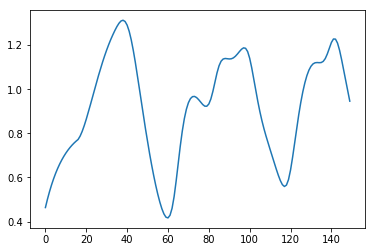

In [9]:
datastruct = data.ToyDataMissing(n_bins=params["N_BINS"])

x = datastruct.simulate()

plt.figure()
plt.plot(x)
plt.show()

do some training with missing values - for this we have to specify the imputing function

In [ ]:
model = models.NADE(datastruct, params=params)

training = models.Training(
                            models.NADE, 
                            "../models/toy_nade_missing", 
                            "../models/toy_nade_missing_training.json",
                            imputer=inference.NaiveSIS(model)
                          )

def print_function(trer, i, batch):
    if i % 10 == 0:
        clear_output()
        print "loss: {}; iteration {}".format(np.mean(trer[-100:]), i)

training.train(print_function)

visualize the training errors

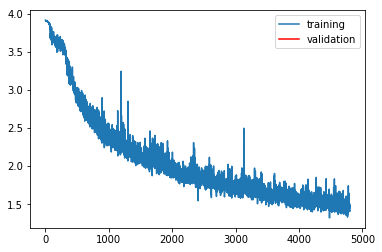

In [34]:
with open("../models/toy_nade_missing_training.json") as f:
    errs = json.load(f)

plt.figure()
plt.plot(np.array(errs["training_error"])[:, 0], 
         np.array(errs["training_error"])[:, 1])
plt.plot(np.array(errs["validation_error"])[:, 0], 
         np.array(errs["validation_error"])[:, 1], 'r')
plt.legend(["training", "validation"])
plt.show()

plot some weight traces

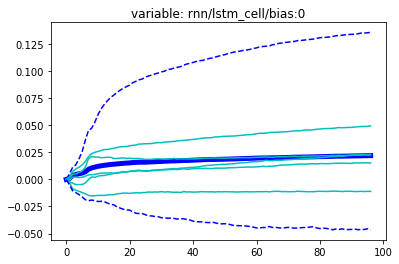

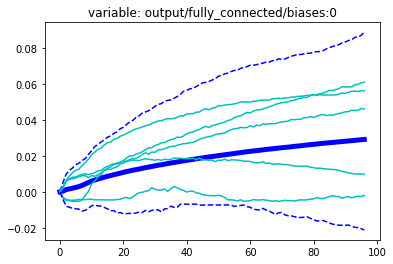

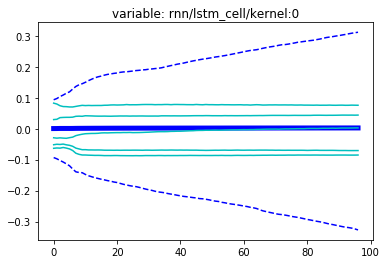

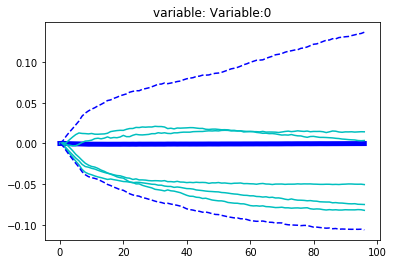

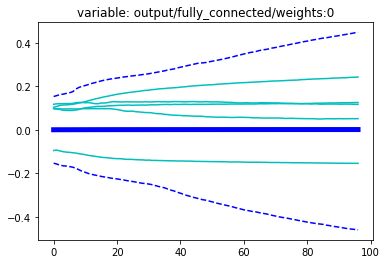

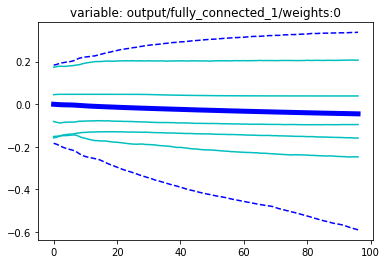

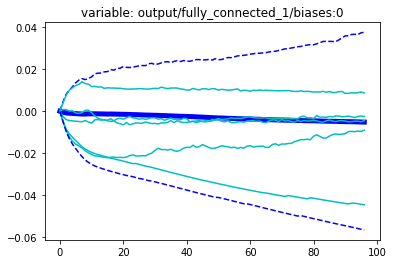

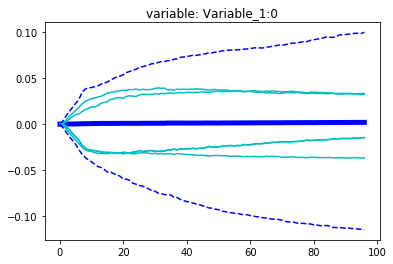

In [35]:
for x in errs.keys():
    if x != "training_error" and x != "validation_error" and "train" not in x:
        plt.figure()
        for key in errs[x].keys():
            if key == "mean":
                plt.plot(errs[x][key], 'b', linewidth=5.0)
            elif key == "random":
                plt.plot(errs[x][key], 'c')
            else:
                plt.plot(errs[x][key], 'b', linestyle='--')

        plt.title("variable: {}".format(x))
plt.show()

load trained model if necessary

In [13]:
load_name = "../models/toy_nade_missing_21000"
model = models.NADE(datastruct, fn=load_name)
print json.dumps(model.params, indent=4)

restoring...
INFO:tensorflow:Restoring parameters from ../models/toy_nade_missing_21000.ckpt
{
    "N_BINS": 50, 
    "LEARNING_RATE": 0.0001, 
    "BATCH_SIZE": 1, 
    "SAVE_EACH": 1000, 
    "N_ITERATIONS": 1000000, 
    "VALIDATE_EACH": 100, 
    "LOG_EVERY": 50, 
    "N_HIDDEN": 128, 
    "N_PARTICLES": 64
}


try some sampling

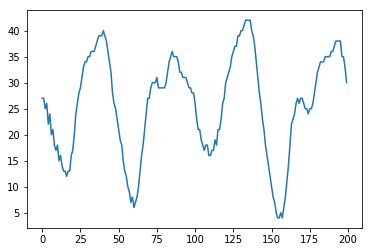

In [14]:
x = model.sample(200)

plt.plot(x)
plt.show()

try some imputation

100%|██████████| 150/150 [00:05<00:00, 27.57it/s]


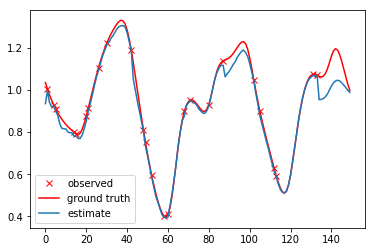

In [15]:
x = datastruct.simulate()
x_missing = np.copy(x)
x_missing[np.random.choice(len(x), replace=False, size=125)] = np.nan

estimate = inference.NaiveSIS(model, x_missing, 1000, binned=False, quiet=False).estimate()

plt.figure()
plt.plot(x_missing, "rx")
plt.plot(x, 'r')
plt.plot(estimate)
plt.legend(["observed", "ground truth", "estimate"])
plt.show()